# CNN
필터를 통해 중요한 특성을 추출하고 학습하는 알고리즘
- 필터 (feature detector) : 밀집층의 뉴런 역할과 같은 역할로, 중요한 특성을 추출한다.
- 커널 : 필터 (filter detector)의 가중치와 절편
---

[구성]
- **Convolutional layer**
  - filter를 통해 중요한 특성을 인식한다.
  - same padding을 통해 입력과 동일 크기로 특성맵을 만든다.
- **Pooling layer**
  - pooling을 통해 변주된 이미지 인식 정확도가 높아진다.
  - 즉 과적합을 막는다.
  - 합성곱 층의 출력값인 특성맵을 최대풀링 혹은 평균 풀링을 통해 크기를 줄인다.
  - 이때, 특성맵 개수는 동일하다.

### load Data

data : fasion MNIST data

keras에 내장된 데이터는 자동으로 train, test가 split되어 반환한다.

In [2]:
from tensorflow import keras

(train_input, train_target), (test_input, test_target) = \
              keras.datasets.fashion_mnist.load_data()
print(train_input.shape, test_input.shape)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
(60000, 28, 28) (10000, 28, 28)


### Data Preparation

📌 합성곱층의 input data는 **3차원**(가로,세로,깊이)이므로 깊이 층을 추가한다.

📌 **scaling**은 Deep learning에서 필수이다.

In [3]:
from sklearn.model_selection import train_test_split

train_scaled = train_input.reshape(-1, 28, 28, 1) / 255.0

# train, validation split
train_scaled, val_scaled, train_target, val_target = train_test_split(
    train_scaled, train_target, test_size=0.2, random_state=42
)

In [4]:
print(train_scaled.shape)

(48000, 28, 28, 1)


### model construct

In [5]:
from tensorflow import keras

model = keras.Sequential()

# convolutional layer 1
model.add(keras.layers.Conv2D(32, kernel_size=3, activation='relu',
                             padding='same', input_shape=(28, 28, 1)))
model.add(keras.layers.MaxPooling2D(2))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:
# convolutional layer 2
model.add(keras.layers.Conv2D(64, kernel_size=3, padding='same',
                              activation='relu'))
model.add(keras.layers.MaxPooling2D(2))

In [7]:
model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(10, activation='softmax'))

In [8]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 100)                 │         313,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 333,526 (1.27 MB)

 Trainable params: 333,526 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

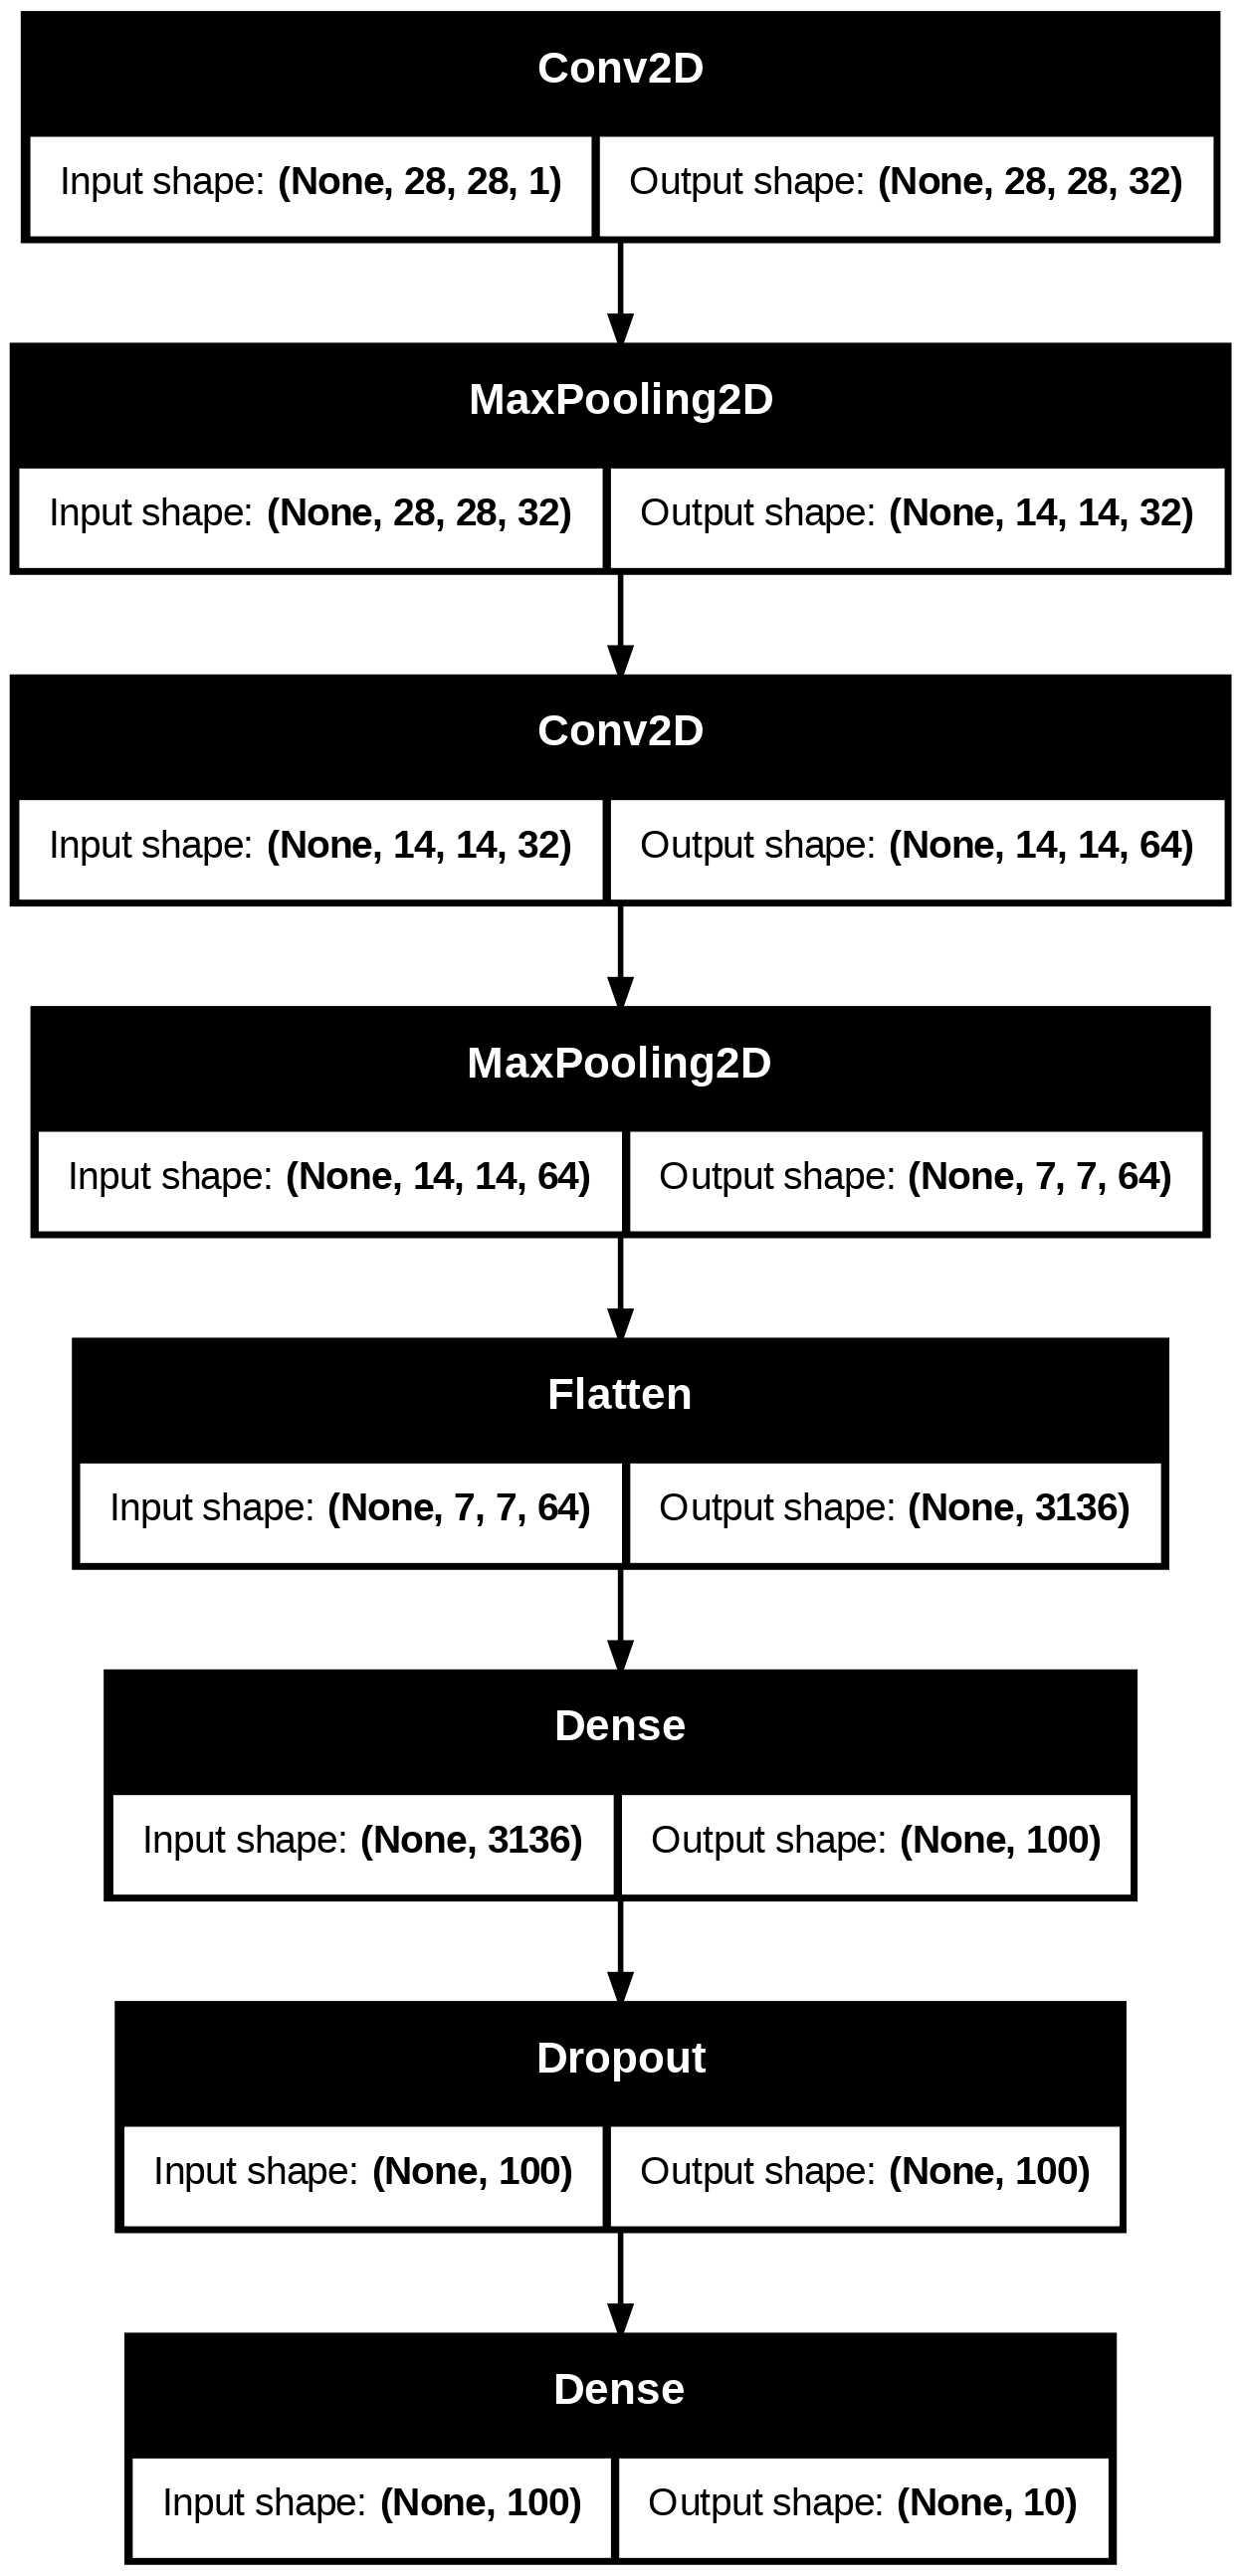

In [9]:
keras.utils.plot_model(model, show_shapes=True)

### Train

- sparse_categorical_crossentropy : target variable을 labeling하지 않은 경우 사용할 수 있다.

- callback
> - **earlyStopping** Callback : 과적합이 되기 이전 train을 종료하여 resource 낭비를 막는다.
> - **modelCheckPoint** Callback : save_best_only = True를 통해 best model을 저장할 수 있다.

In [11]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# callback
checkpoints_cb = keras.callbacks.ModelCheckpoint('best-cnn-model.keras', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)

history = model.fit(train_scaled, train_target, epochs=20,
                    validation_data=(val_scaled, val_target),
                    callbacks=[checkpoints_cb, early_stopping_cb])

Epoch 1/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.7034 - loss: 0.8203 - val_accuracy: 0.8693 - val_loss: 0.3596
Epoch 2/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.8508 - loss: 0.4157 - val_accuracy: 0.8857 - val_loss: 0.3078
Epoch 3/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8744 - loss: 0.3483 - val_accuracy: 0.8942 - val_loss: 0.2813
Epoch 4/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8865 - loss: 0.3166 - val_accuracy: 0.9049 - val_loss: 0.2615
Epoch 5/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8965 - loss: 0.2854 - val_accuracy: 0.9130 - val_loss: 0.2407
Epoch 6/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9052 - loss: 0.2617 - val_accuracy: 0.9093 - val_loss: 0.2402
Epoch 7/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9111 - loss: 0.2463 - val_accuracy: 0.9171 - val_loss: 0.2276
Epoch 8/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9146 - loss: 0.2303 

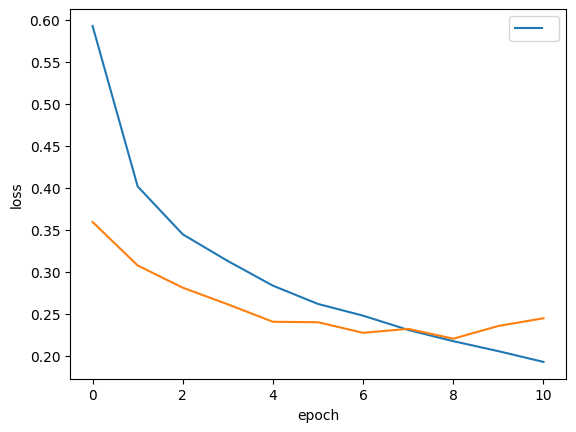

In [12]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend([''])
plt.show()

In [13]:
early_stopping_cb.best_epoch

8

In [14]:
model.evaluate(val_scaled, val_target)

375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9183 - loss: 0.2158


[0.22058872878551483, 0.9178333282470703]

### Predict

sample data로 validation data의 첫번재 data를 사용해서 예측해보자.

In [15]:
val_scaled.shape

(12000, 28, 28, 1)

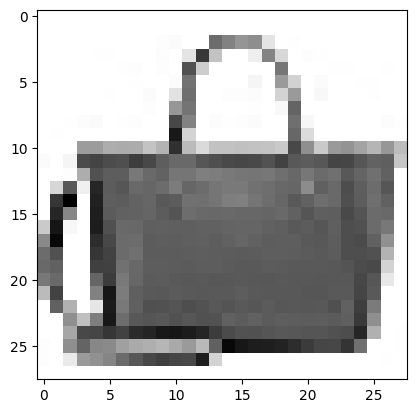

In [16]:
plt.imshow(val_scaled[0].reshape(28, 28), cmap='gray_r')
plt.show()

In [17]:
print(val_scaled[0:1].shape)

pred = model.predict(val_scaled[0:1])
print(pred)

(1, 28, 28, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step
[[5.3628022e-20 6.1413253e-30 1.0256054e-24 1.0857095e-22 9.1292467e-22
  5.2715569e-17 4.1609108e-18 9.7152581e-21 1.0000000e+00 8.0415794e-22]]


fit(), predict(), evaluate() 메서드는 모두 **첫번째 차원이 배치차원**일 것으로 기대한다.
> 배치차원 : 모델이 한 번에 처리할 입력 데이터 묶음

val_scaled[0] 은 (28, 28, 1)이다.

이때, **slicing**을 하면 **전체 차원이 유지**되어 val_scaled[0:1]은 (1, 28, 28, 1)이다.

### Plot

e: 지수 표현으로, e-3 == 10^3

따라서 위 predict 결과를 보면 9번째 class일 확률이 1에 가깝다는 것을 알 수 있다.

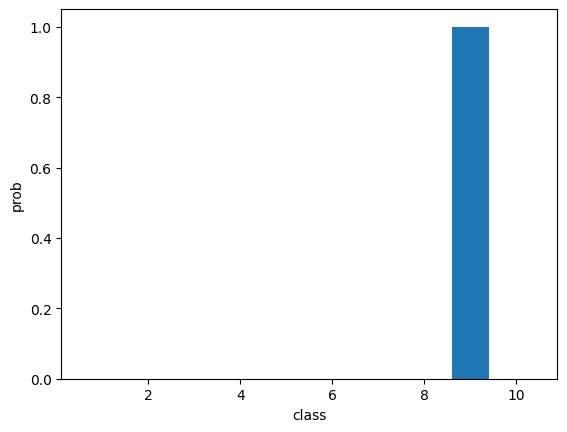

In [18]:
plt.bar(range(1, 11), pred[0])
plt.xlabel('class')
plt.ylabel('prob')
plt.show()

In [19]:
classes=['티셔츠', '바지', '스웨터', '드레스', '코트', '샌달', '셔츠', '스니커즈', '가방', '앵클부츠']

예측한 category 확인

In [20]:
import numpy as np
print(classes[np.argmax(pred)])

가방


일반화 성능 평가

In [21]:
test_scaled = test_input.reshape(-1, 28, 28, 1)

model.evaluate(test_scaled, test_target)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8740 - loss: 38.3316


[37.40652847290039, 0.8747000098228455]